Calibrated Parameters:
Drift (mu): 0.42344457
Volatility (sigma): 0.15320984
Jump Intensity (lambda): 1012.79845016
Jump Mean (m): -0.00154790
Jump Variance (v): 0.00008302


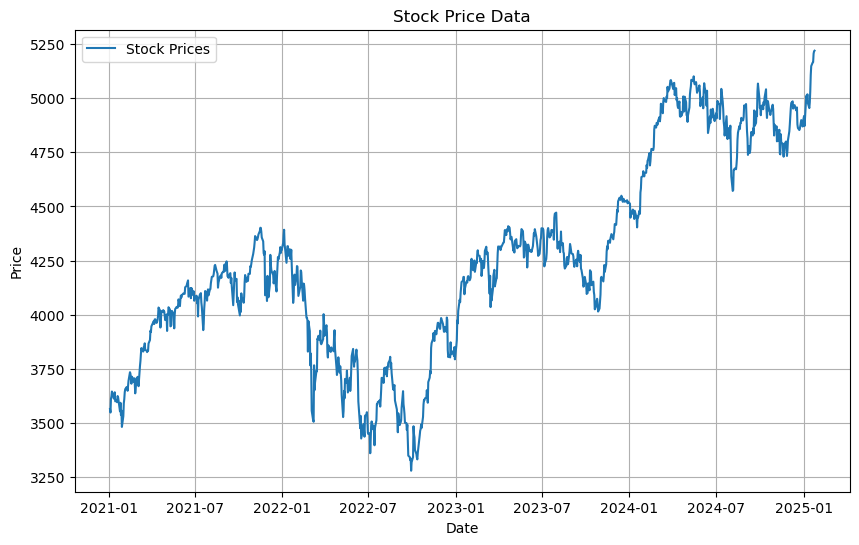

In [78]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math

class StockDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_and_clean_data(self):
        """Load and preprocess stock price data."""
        self.data = pd.read_csv(self.file_path, parse_dates=['Date'])
        for col in ['Price','Open', 'High', 'Low']:
            self.data[col] = self.data[col].str.replace(',', '').astype(float)
        self.data = self.data.sort_values('Date')
        return self.data

class MertonJumpDiffusion:
    def __init__(self, dt):
        self.dt = dt
        self.params = None

    @staticmethod
    def _log_likelihood(params, data, dt):
        """Compute the negative log-likelihood for the Merton Jump Diffusion model."""
        mu, sigma, lam, m, v = params
        if sigma <= 0 or lam < 0 or v <= 0:
            return np.inf

        log_returns = np.log(data[1:] / data[:-1])
        jump_drift = lam * (np.exp(m + 0.5 * v) - 1)
        drift = (mu - 0.5 * sigma**2 - jump_drift) * dt
        diffusion = sigma * np.sqrt(dt)

        likelihoods = []
        for r in log_returns:
            jump_terms = [
                (np.exp(-(r - drift - k * m)**2 / (2 * (sigma**2 * dt + k * v))) /
                 np.sqrt(2 * np.pi * (sigma**2 * dt + k * v)))
                * (np.exp(-lam * dt) * (lam * dt)**k) / math.factorial(k)
                for k in range(10)
            ]
            likelihoods.append(np.sum(jump_terms))

        return -np.sum(np.log(likelihoods))

    def calibrate(self, prices):
        """Calibrate the model parameters to observed price data."""
        initial_params = [0.1, 0.2, 0.5, -0.1, 0.1]
        bounds = [(-np.inf, np.inf), (1e-5, np.inf), (0, np.inf), (-np.inf, np.inf), (1e-5, np.inf)]

        result = minimize(
            self._log_likelihood, initial_params, args=(prices, self.dt),
            bounds=bounds, method='L-BFGS-B'
        )

        if result.success:
            self.params = result.x
        else:
            raise ValueError("Calibration failed.")

        return self.params

    def get_calibrated_params(self):
        if self.params is None:
            raise ValueError("Model is not calibrated yet.")
        return self.params

class MertonJumpDiffusionPlotter:
    @staticmethod
    def plot_prices(data, prices):
        """Plot stock price data."""

        plt.figure(figsize=(10, 6))
        plt.plot(data['Date'], prices, label="Stock Prices")
        plt.title("Stock Price Data")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    file_path = "StoxxLarger.csv"

    loader = StockDataLoader(file_path)
    data = loader.load_and_clean_data()
    prices = data['Price'].values
    dt = 1 / (252*4)  # Daily data (252 trading days per year)

    model = MertonJumpDiffusion(dt)
    try:
        calibrated_params = model.calibrate(prices)
        mu, sigma, lam, m, v = calibrated_params
        print(f"Calibrated Parameters:")
        print(f"Drift (mu): {mu:.8f}")
        print(f"Volatility (sigma): {sigma:.8f}")
        print(f"Jump Intensity (lambda): {lam:.8f}")
        print(f"Jump Mean (m): {m:.8f}")
        print(f"Jump Variance (v): {v:.8f}")
    except ValueError as e:
        print(e)

    plotter = MertonJumpDiffusionPlotter()
    plotter.plot_prices(data, prices)


3564.39


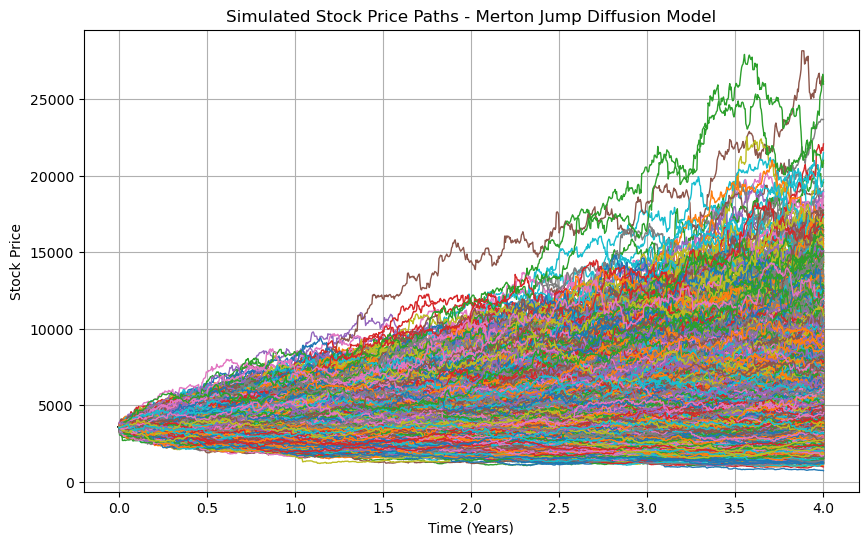

In [84]:
import numpy as np
import matplotlib.pyplot as plt


def merton_jump_diffusion(S0, mu, sigma, lam, m, v, T, N, paths):
    """
    Simulate stock price paths using the Merton Jump Diffusion Model.

    Parameters:
        S0 (float): Initial stock price.
        mu (float): Drift coefficient (expected return).
        sigma (float): Volatility of the stock.
        lam (float): Intensity of the Poisson process (mean number of jumps per year).
        m (float): Mean of the jump size (log-normal jump distribution).
        v (float): Variance of the jump size (log-normal jump distribution).
        T (float): Time horizon (in years).
        N (int): Number of time steps.
        paths (int): Number of simulated paths.

    Returns:
        np.ndarray: Simulated stock price paths.
    """
    dt = 1/(252*4)
    jump_drift = lam * (np.exp(m + 0.5 * v) - 1)
    drift = (mu - 0.5 * sigma**2 - jump_drift) * dt
    diffusion = sigma * np.sqrt(dt)


    stock_paths = np.zeros((paths, N + 1))
    stock_paths[:, 0] = S0

    for t in range(1, N + 1):
        # Simulate standard Brownian motion component
        Z = np.random.normal(0, 1, paths)
        # Simulate the Poisson jump component
        J = np.random.poisson(lam * dt, paths)
        # Simulate the jump sizes
        Y = np.random.normal(m, np.sqrt(v), paths)
        jump_sizes = J * (np.exp(Y) - 1)

        # Update stock prices
        stock_paths[:, t] = stock_paths[:, t - 1] * np.exp(drift + diffusion * Z) * (1 + jump_sizes)

    return stock_paths


if __name__ == "__main__":
    S0 = prices[0]  # Initial stock price 
    T = 4         # Time horizon 
    N = 252*4       # Number of time steps (daily steps)
    paths = 10000   # Number of simulated paths

    try:
        mu, sigma, lam, m, v = calibrated_params
        simulated_paths = merton_jump_diffusion(S0, mu, sigma, lam, m, v, T, N, paths)

       
        plt.figure(figsize=(10, 6))
        for i in range(paths):
            plt.plot(np.linspace(0, T, N + 1), simulated_paths[i], lw=1)
        plt.title("Simulated Stock Price Paths - Merton Jump Diffusion Model")
        plt.xlabel("Time (Years)")
        plt.ylabel("Stock Price")
        plt.grid(True)
        plt.show()

    except NameError:
        print("Calibrated parameters are missing.")


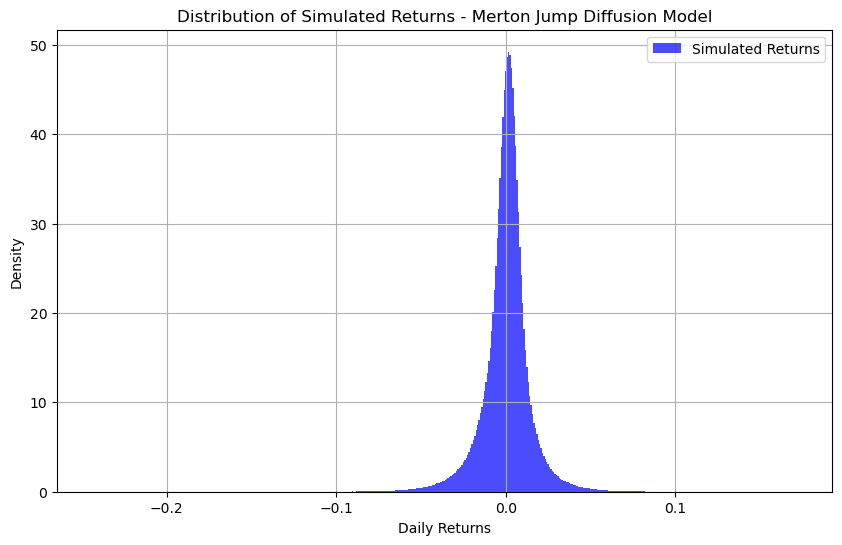

In [80]:

returns = (simulated_paths[:, 1:] / simulated_paths[:, :-1]) - 1  # Daily returns
flattened_returns = returns.flatten()  


plt.figure(figsize=(10, 6))
plt.hist(flattened_returns, bins=500, density=True, alpha=0.7, color="blue", label="Simulated Returns")
plt.title("Distribution of Simulated Returns - Merton Jump Diffusion Model")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()



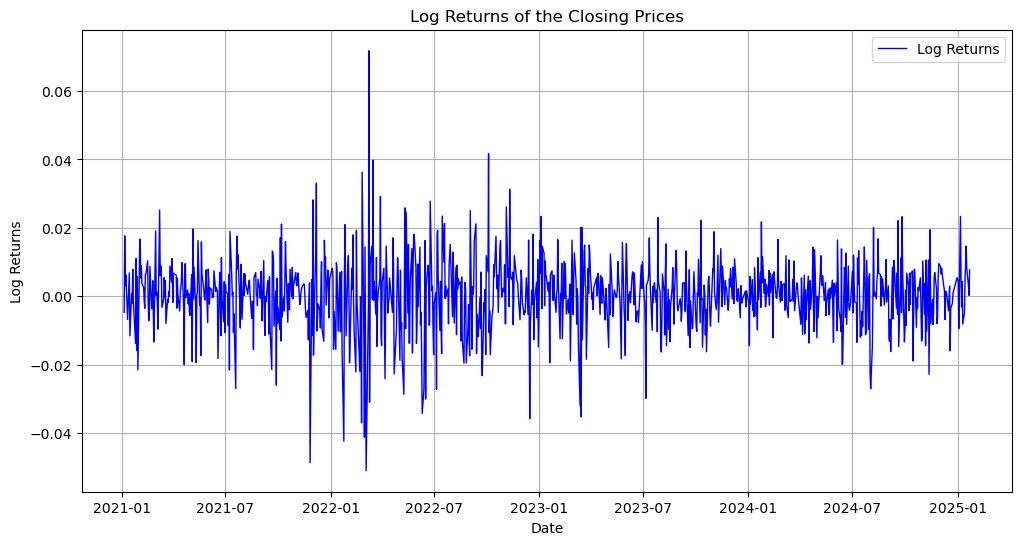

In [81]:
file_path = "StoxxLarger.csv"  
data = pd.read_csv(file_path, parse_dates=['Date'])

data['Price'] = data['Price'].str.replace(',', '').astype(float)
data = data.sort_values('Date')  


data['Log_Returns'] = np.log(data['Price'] / data['Price'].shift(1))
data = data.dropna()  


training_log_returns = data['Log_Returns'].values


plt.figure(figsize=(12, 6))
plt.plot(data['Date'], training_log_returns, label="Log Returns", color="blue", linewidth=1)
plt.title("Log Returns of the Closing Prices")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.grid(True)
plt.legend()
plt.show()


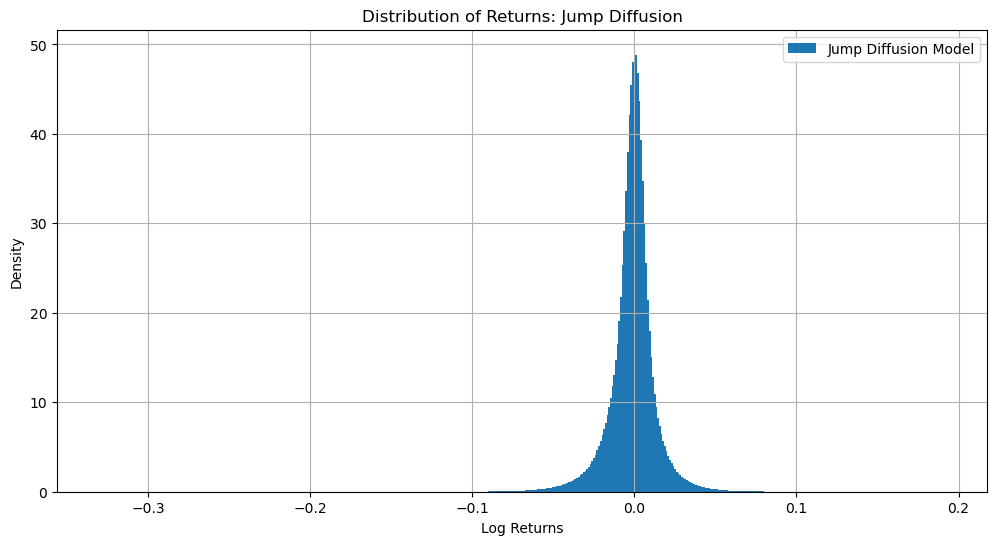

In [85]:
np.random.seed(42)


def simulate_jump_diffusion(n, mu, sigma, lam, m, v, dt):
    normal_component = np.random.normal(mu * dt, sigma * np.sqrt(dt), size=n)
    jump_component = np.random.poisson(lam * dt, size=n) * np.random.normal(m, np.sqrt(v), size=n)
    return normal_component + jump_component

#jump_diffusion_returns = simulate_jump_diffusion(len(training_log_returns), mu, sigma, lam, m, v, dt)

jump_diffusion_returns = simulate_jump_diffusion(10000000, mu, sigma, lam, m, v, dt)

bins = 500
plt.figure(figsize=(12, 6))

plt.hist(jump_diffusion_returns, bins=bins, density=True, alpha=1, label="Jump Diffusion Model")

plt.title("Distribution of Returns: Jump Diffusion")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


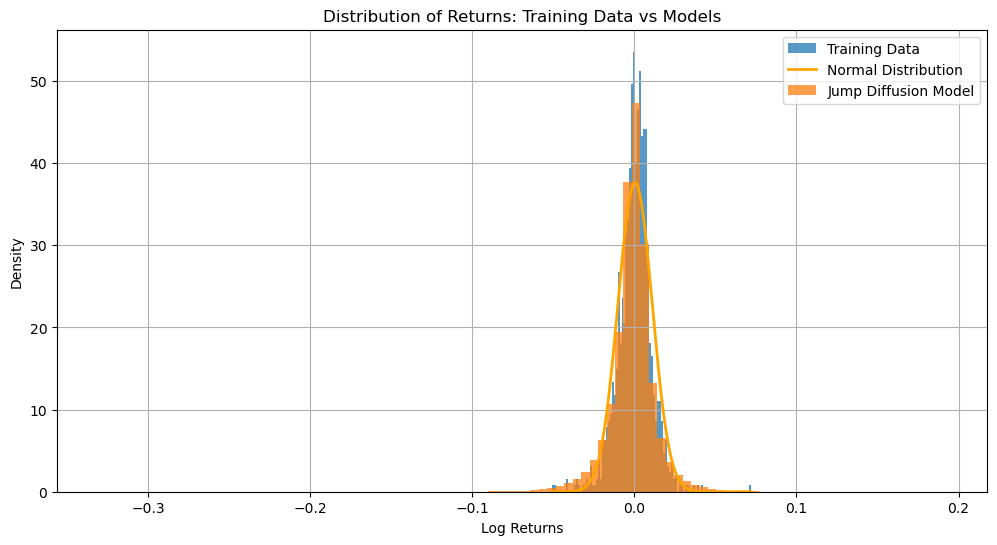

In [86]:
from scipy.stats import norm


np.random.seed(42)

normal_fitted = norm.fit(training_log_returns)

bins = 100
plt.figure(figsize=(12, 6))

# Training data histogram
plt.hist(training_log_returns, bins=bins, density=True, alpha=0.75, label="Training Data")

# Normal distribution (fitted to training data)
x = np.linspace(min(training_log_returns), max(training_log_returns), 1000)
plt.plot(x, norm.pdf(x, *normal_fitted), label="Normal Distribution", color="orange", linewidth=2)

# Jump diffusion distribution (histogram)
plt.hist(jump_diffusion_returns, bins=bins, density=True, alpha=0.75, label="Jump Diffusion Model")

plt.title("Distribution of Returns: Training Data vs Models")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
